<a href="https://colab.research.google.com/github/Aditya-Walia1/Stock-Price-Prediction/blob/main/Updated_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv1D, Add, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:

# Load the dataset
file_path = '/content/AMZN.csv'
data = pd.read_csv(file_path)

# Select the 'Close' column
close_prices = data['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(close_prices_scaled, seq_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the ResNet-like model
input_layer = Input(shape=(seq_length, 1))


In [3]:

# First convolutional block with Dropout
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)

# Residual connection
x = Add()([x, input_layer])

# Second convolutional block with Dropout
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)

# Residual connection
x = Add()([x, input_layer])

# Flatten and output
x = Flatten()(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an adjusted learning rate
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [4]:

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and true values to get the original scale
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0056 - val_loss: 2.1998e-04 - learning_rate: 0.0010
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 1.5442e-05 - val_loss: 8.5827e-05 - learning_rate: 0.0010
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.1797e-05 - val_loss: 5.5884e-05 - learning_rate: 0.0010
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.0242e-05 - val_loss: 1.0633e-04 - learning_rate: 0.0010
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.9213e-06 - val_loss: 4.9443e-05 - learning_rate: 0.0010
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 6.6535e-06 - val_loss: 6.8724e-05 - learning_rate: 0.0010
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.1692e-05 - val_loss: 2.6007e-04 - learning_rate: 0.0010
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 6.6455e-06 - val_loss: 3.9549e-05 - learning_rate: 5.0000e-04
Epoch 9/100
146/146 ━━━━━━━━━━━━━━━━━━━

RMSE: 4.394088373652654
MAE: 3.267935901601124
MAPE: 2.7374288751778937


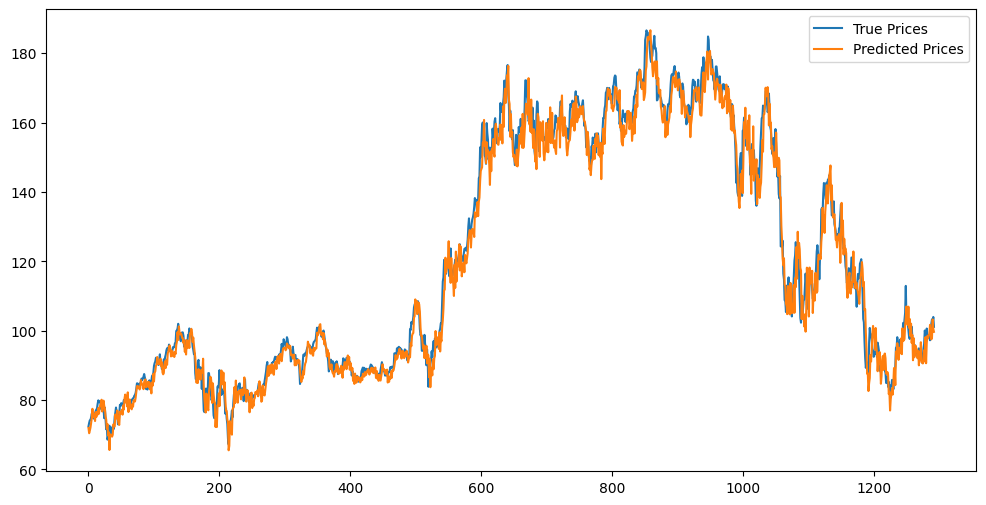

In [5]:

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
print(f'RMSE: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print(f'MAE: {mae}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / y_test_inverse)) * 100
print(f'MAPE: {mape}')

# Plot the predictions against the true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Prices')
plt.plot(predictions_inverse, label='Predicted Prices')
plt.legend()
plt.show()
